In [ ]:
from torchinfo import summary
import numpy as np
from torchvision.models.vision_transformer import ViT_B_16_Weights
from torchvision.models.vision_transformer import vit_b_16
from pathlib import Path
import math

from hyperparams import *
import data
import eval
import vit
import train
import utils

In [2]:
import importlib
def reload():
    importlib.reload(data)
    importlib.reload(eval)
    importlib.reload(vit)
    importlib.reload(train)
    importlib.reload(utils)

In [4]:
device = utils.get_device()

Using device: mps


In [5]:
BATCH = 32

Prepare data

In [6]:
imagenette2_path = data.download_imagenette2()

Imagenette2 is already downloaded! /Users/yehormanevych/Projects/ViT/datasets/imagenette2


In [7]:
imagenet_classes_path = Path('imagenet_class_index.json')
data_path, classes = data.format_imagenette2(imagenet_classes_path)

Imagenette2 dataset is already formatted and exists at /Users/yehormanevych/Projects/ViT/datasets/imagenette2_format


Load data

In [8]:
train_data_path= data_path/'train'
test_data_path= data_path/'test'
train_ds, test_ds, train_dl, test_dl = data.load_imagenette2(classes, BATCH, ViT_B_16_Weights.DEFAULT.transforms())

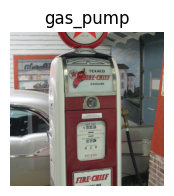

In [9]:
utils.show(test_ds, 31)

Eval the reference model

In [10]:
print("Creating the reference model")
weights = ViT_B_16_Weights.DEFAULT
ref_model = vit_b_16(weights=weights).to(device)

Creating the reference model


In [11]:
print("Evaluating the reference model")
metrics = eval.eval(ref_model, test_dl, len(test_ds.classes), device)
print(metrics)
print("Precision and Recall are low because the model is only evaluated on a suabset of IMAGENET classes")

Evaluating the reference model


Evaluating:   0%|          | 0/123 [00:00<?, ?it/s]

{'Accuracy': tensor(0.9299), 'Loss': tensor(0.0104), 'Precision': tensor(0.1176), 'Recall': tensor(0.1091)}
Precision and Recall are low because the model is only evaluated on a suabset of IMAGENET classes


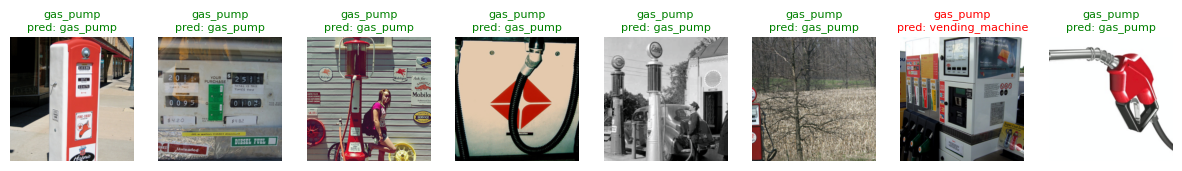

In [13]:
eval.eval_show(ref_model, test_ds, n=8, page=2)

Replication

In [14]:
print("Creating the replicated model")
m = vit.ViT(D, IMAGE_W, PATCH, HEADS, DMLP, L, len(classes), DROPOUT, NORM_EPS)
print(summary(m, depth=4, input_size=(1, 3, IMAGE_W, IMAGE_W),col_names=["kernel_size", "input_size", "output_size", "num_params"], row_settings=["var_names"],))

Creating the replicated model
Layer (type (var_name))                       Kernel Shape              Input Shape               Output Shape              Param #
ViT (ViT)                                     --                        [1, 3, 224, 224]          [1, 1000]                 768
├─Conv2d (conv_proj)                          [16, 16]                  [1, 3, 224, 224]          [1, 768, 14, 14]          590,592
├─Flatten (flatten)                           --                        [1, 768, 14, 14]          [1, 768, 196]             --
├─Encoder (encoder)                           --                        [1, 197, 768]             [1, 197, 768]             151,296
│    └─Sequential (layers)                    --                        [1, 197, 768]             [1, 197, 768]             --
│    │    └─EncoderBlock (0)                  --                        [1, 197, 768]             [1, 197, 768]             --
│    │    │    └─LayerNorm (ln_1)             --                 

In [15]:
print("State keys of the replicated model:")
state = m.state_dict()
keys = np.array(list(state.keys()))

max_len = -1
max_i = -1
for i, k in enumerate(keys):
    if(len(k) >= max_len):
        max_len = len(k)
        max_i = i

rows = 10
pad_end = math.ceil(len(keys)/rows)*rows - len(keys)
keys = np.pad(keys, (0,pad_end), constant_values='')

margin  = 4
lines = np.stack(np.array_split(keys, int(len(keys)/rows))).T
for l in lines:
    print((' ' * margin).join([str(key).ljust(max_len) for key in l]))

State keys of the replicated model:
class_token                          encoder.layers.0.ln_2.weight         encoder.layers.1.msa.w0              encoder.layers.2.msa.qkv             encoder.layers.3.ln_1.weight         encoder.layers.3.mlp.lin2.weight     encoder.layers.4.mlp.lin1.weight     encoder.layers.5.ln_2.weight         encoder.layers.6.msa.w0              encoder.layers.7.msa.qkv             encoder.layers.8.ln_1.weight         encoder.layers.8.mlp.lin2.weight     encoder.layers.9.mlp.lin1.weight     encoder.layers.10.ln_2.weight        encoder.layers.11.msa.w0             head.weight                      
conv_proj.weight                     encoder.layers.0.ln_2.bias           encoder.layers.1.msa.w0_bias         encoder.layers.2.msa.qkv_bias        encoder.layers.3.ln_1.bias           encoder.layers.3.mlp.lin2.bias       encoder.layers.4.mlp.lin1.bias       encoder.layers.5.ln_2.bias           encoder.layers.6.msa.w0_bias         encoder.layers.7.msa.qkv_bias        encod

In [16]:
print("Updating the parameters of the replicated model")
ref_state = ViT_B_16_Weights.DEFAULT.get_state_dict(progress=True)

state["class_token"] = ref_state["class_token"].squeeze()
state["conv_proj.weight"] = ref_state["conv_proj.weight"]
state["conv_proj.bias"] = ref_state["conv_proj.bias"]
state["encoder.pos_embeddings"] = ref_state["encoder.pos_embedding"]
for l in range(L):
    state[f"encoder.layers.{l}.ln_1.weight"] = ref_state[f"encoder.layers.encoder_layer_{l}.ln_1.weight"]
    state[f"encoder.layers.{l}.ln_1.bias"] = ref_state[f"encoder.layers.encoder_layer_{l}.ln_1.bias"]
    state[f"encoder.layers.{l}.msa.qkv"] = ref_state[f"encoder.layers.encoder_layer_{l}.self_attention.in_proj_weight"]
    state[f"encoder.layers.{l}.msa.qkv_bias"] = ref_state[f"encoder.layers.encoder_layer_{l}.self_attention.in_proj_bias"]
    state[f"encoder.layers.{l}.msa.w0"] = ref_state[f"encoder.layers.encoder_layer_{l}.self_attention.out_proj.weight"]
    state[f"encoder.layers.{l}.msa.w0_bias"] = ref_state[f"encoder.layers.encoder_layer_{l}.self_attention.out_proj.bias"]
    state[f"encoder.layers.{l}.ln_2.weight"] = ref_state[f"encoder.layers.encoder_layer_{l}.ln_2.weight"]
    state[f"encoder.layers.{l}.ln_2.bias"] = ref_state[f"encoder.layers.encoder_layer_{l}.ln_2.bias"]
    state[f"encoder.layers.{l}.mlp.lin1.weight"] = ref_state[f"encoder.layers.encoder_layer_{l}.mlp.linear_1.weight"]
    state[f"encoder.layers.{l}.mlp.lin1.bias"] = ref_state[f"encoder.layers.encoder_layer_{l}.mlp.linear_1.bias"]
    state[f"encoder.layers.{l}.mlp.lin2.weight"] = ref_state[f"encoder.layers.encoder_layer_{l}.mlp.linear_2.weight"]
    state[f"encoder.layers.{l}.mlp.lin2.bias"] = ref_state[f"encoder.layers.encoder_layer_{l}.mlp.linear_2.bias"]
state["encoder.ln.weight"] = ref_state["encoder.ln.weight"]
state["encoder.ln.bias"] = ref_state["encoder.ln.bias"]
state["head.weight"] = ref_state["heads.head.weight"]
state["head.bias"] = ref_state["heads.head.bias"]

m.load_state_dict(state)

Updating the parameters of the replicated model


<All keys matched successfully>

In [ ]:
print("Evaluating the replicated model")
metrics = eval.eval(m, test_dl, len(test_ds.classes), device)
print(metrics)
print("Precision and Recall are low because the model is only evaluated on a suabset of IMAGENET classes")

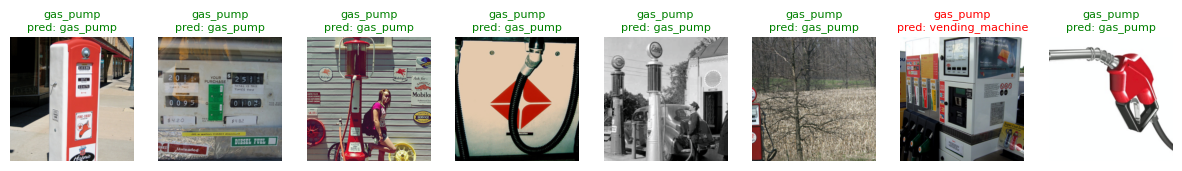

In [30]:
eval.eval_show(m, test_ds, 8, page=2)

In [17]:
print("Saving the replicated modet")
utils.save_model(m, accuracy=metrics[eval.Metrics.ACCURACY.value].item())

Saving the replicated modet
Model is saved to /Users/yehormanevych/Projects/ViT/models/2023-08-30_16.25.28_ViT_93%_.pth


PosixPath('models/2023-08-30_16.25.28_ViT_93%_.pth')